In [217]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn
import time
import os
import logging

from torch.utils.data import DataLoader


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-sets/RecoOutPileup_TimeMod_uniform_1_recohitfile_training_data.csv
/kaggle/input/data-sets/RecoOutPileup_TimeMod_uniform_1_recohitfile_testing_data.csv


In [218]:

# Define the radius of the epsilon ball
epsilon = 0.001

point_index = 34

In [219]:
#Import all the libraries
#Install trackml, run these 3 seperately

!pip install trackml
# pip install --user git+https://github.com/LAL/trackml-library
# import trackml

In [220]:
pip install --user git+https://github.com/LAL/trackml-library

  Cloning https://github.com/LAL/trackml-library to /tmp/pip-req-build-rx7w6e3p
  Running command git clone --filter=blob:none --quiet https://github.com/LAL/trackml-library /tmp/pip-req-build-rx7w6e3p
  Resolved https://github.com/LAL/trackml-library to commit 53a165e15a2c885f54c2bef1bd1ed53db6ed9648
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [221]:
import trackml

In [222]:
#defining the class
from torch.utils.data import Dataset


#####################################
#               DATASET             #
#####################################

class Hit_Pair_Dataset(Dataset):
    def __init__(self, data_filepath, nb_samples):
        dataset = pd.read_csv("/kaggle/input/data-sets/RecoOutPileup_TimeMod_uniform_1_recohitfile_training_data.csv")

        try:
            self.hits_a = np.array(dataset[['x1_normed', 'y1_normed', 'z1_normed']][:nb_samples], dtype=np.float32)
            self.hits_b = np.array(dataset[['x2_normed', 'y2_normed', 'z2_normed']][:nb_samples], dtype=np.float32)
            self.target = np.array(dataset['label'][:nb_samples], dtype=np.float32)
            self.time1 = np.array(dataset['t1'][:nb_samples], dtype=np.float32)
            self.muon1 = np.array(dataset['muonID1'][:nb_samples], dtype=np.float32)
        
        except:
            dim = (dataset.shape[1] - 1) // 2
            self.hits_a = dataset[:nb_samples, :dim]
            self.hits_b = dataset[:nb_samples, dim:2 * dim]
            self.target = dataset[:nb_samples, -1]
            self.time1 = dataset[:nb_samples, -1]
            self.muon1 = dataset[:nb_samples, -1]
            

    def __getitem__(self, index):
        h_a = self.hits_a[index]
        h_b = self.hits_b[index]
        t = self.target[index]
        ti = self.time1[index]
        mi = self.muon1[index]
        return h_a, h_b, t, ti, mi

    def __len__(self):
        return len(self.hits_a)

    def get_dim(self):
        return self.hits_a.shape[1]

In [223]:
dataset = Hit_Pair_Dataset("/kaggle/input/data-sets/RecoOutPileup_TimeMod_uniform_1_recohitfile_training_data.csv", nb_samples=16578)

In [224]:
#MLP model to embed the hit points


class MLP(nn.Module):
    def __init__(self,
                 nb_hidden,
                 nb_layer,
                 input_dim,
                 mean,
                 std,
                 emb_dim=3):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_dim, nb_hidden)]
        ln = [nn.Linear(nb_hidden, nb_hidden) for _ in range(nb_layer-1)]
        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(nb_hidden, emb_dim)
        self.act = nn.ReLU()
        self.mean = torch.FloatTensor(mean).to(torch.float)
        self.std = torch.FloatTensor(std).to(torch.float)

    def forward(self, hits):
        hits = self.normalize(hits)
        for l in self.layers:
            hits = l(hits)
            hits = self.act(hits)
            # hits = self.dropout(hits)
        hits = self.emb_layer(hits)
        return hits

    def normalize(self, hits):

        return hits

mlp = MLP(nb_hidden=128, nb_layer=3, input_dim=3, mean=[0,0,0], std=[1,1,1])
print("MLP model:", mlp)

MLP model: MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
  )
  (emb_layer): Linear(in_features=128, out_features=3, bias=True)
  (act): ReLU()
)


In [225]:
#score calculation: correctly predicted labels/total labels

def score_dist_accuracy(pred, true):
    pred_classes = torch.ones_like(pred)  # Initialize all predictions as 1
    pred_classes[pred >= 0.1] = -1 
    correct = pred_classes == true
    nb_correct = correct.sum().item()
    nb_total = true.size(0)
    score = nb_correct / nb_total
    return score

In [226]:
####################
#     PRINTING     #
####################
def print_header():
  '''
  Print header before train / evaluation run.
  '''
  logging.info("         Loss  Score")

def print_eval_stats(nb_processed, loss, score):
  '''
  Log stats during train, evaluation run.
  '''
  logging.info("  {:5d}: {:.3f}  {:2.2f}".format(nb_processed, loss, score))
    
#spliting the dataset for training and evaluation

from torch.utils.data import random_split

import torch
from torch.utils.data import DataLoader


from sklearn.model_selection import train_test_split


# Split the dataset into training and validation subsets
train_ratio = 0.8
valid_ratio = 0.2
train_size = int(train_ratio * len(dataset))
valid_size = len(dataset) - train_size

# train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_dataset, valid_dataset = train_test_split(dataset, test_size=0.2, random_state=42)


# Create data loaders for training and validation
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [227]:

# Check if a GPU is available, otherwise use CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = dataset.get_dim()
net = MLP(input_dim=3, nb_hidden=256, nb_layer=3,mean=[0,0,0], std=[1,1,1], emb_dim=3)
net.to(DEVICE)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1-2): 2 x Linear(in_features=256, out_features=256, bias=True)
  )
  (emb_layer): Linear(in_features=256, out_features=3, bias=True)
  (act): ReLU()
)

In [228]:
#defining the model for training one epoch


model_dir = "/kaggle/working/model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


def train_one_epoch(net, batch_size, optimizer, train_loader):
  net.train()

  nb_batch = len(train_loader)
  nb_train = nb_batch * batch_size
  epoch_score = 0
  epoch_loss  = 0


  logging.info("Training on {} samples".format(nb_train))
  print_header()
  t0 = time.time()
  elapsed = 0
  for i, (hits_a, hits_b, target, time1, muon1) in enumerate(train_loader):
    hits_a = hits_a.to(DEVICE, non_blocking=True)
    hits_b = hits_b.to(DEVICE, non_blocking=True)
    target = target.to(DEVICE, non_blocking=True)
    time1 = time1.to(DEVICE, non_blocking=True)
    muon1 = muon1.to(DEVICE, non_blocking=True)
    '''
    hits_a = hits_a.to(DEVICE)
    hits_b = hits_b.to(DEVICE)
    target = target.to(DEVICE)
    '''
    optimizer.zero_grad()

    emb_h_a = net(hits_a)
    emb_h_b = net(hits_b)

    pred = nn.functional.pairwise_distance(emb_h_a,emb_h_b)
    true_dist = target
    loss = nn.functional.hinge_embedding_loss(pred,true_dist)
    
    torch.nn.HingeEmbeddingLoss(margin=1.0, size_average=None, reduce=None, reduction='mean')

    loss.backward()
    optimizer.step()

    score = score_dist_accuracy(pred, target)
    epoch_score += score * 100
    epoch_loss  += loss.item()

    nb_proc = (i+1) * batch_size
    if (((i+0) % (nb_batch//10)) == 0):
        print_eval_stats(nb_proc,
                               epoch_loss/(i+1),
                               epoch_score/(i+1))

  logging.info("Model elapsed:  {:.2f}".format(elapsed))

  # Save the trained model
  torch.save(net.state_dict(), os.path.join(model_dir, "trained_model.pt"))

  return epoch_loss / nb_batch, epoch_score / nb_batch

#   Save the trained model
# torch.save(net.state_dict(), os.path.join(model_dir, "trained_model.pt"))


def evaluate(net, batch_size, valid_loader):
    net.eval()

    nb_batch = len(valid_loader)
    nb_valid = nb_batch * batch_size
    valid_score = 0
    valid_loss = 0

    logging.info("Evaluating on {} samples".format(nb_valid))
    print_header()
    t0 = time.time()
    elapsed = 0
    with torch.no_grad():
        for i, (hits_a, hits_b, target, time1, muon1) in enumerate(valid_loader):
            hits_a = hits_a.to(DEVICE, non_blocking=True)
            hits_b = hits_b.to(DEVICE, non_blocking=True)
            target = target.to(DEVICE, non_blocking=True)
            time1 = time1.to(DEVICE, non_blocking=True)
            muon1 = muon1.to(DEVICE, non_blocking=True)

            emb_h_a = net(hits_a)
            emb_h_b = net(hits_b)

            pred = nn.functional.pairwise_distance(emb_h_a, emb_h_b)
            true_dist = target
            loss = nn.functional.hinge_embedding_loss(pred, true_dist)

            score = score_dist_accuracy(pred, target)
            valid_score += score * 100
            valid_loss += loss.item()

            nb_proc = (i + 1) * batch_size
            if (((i + 0) % (nb_batch // 10)) == 0):
                print_eval_stats(nb_proc, valid_loss / (i + 1), valid_score / (i + 1))
                
            # Save the evaluated model
            torch.save(net.state_dict(), os.path.join(model_dir, "evaluated_model.pt"))

    logging.info("Model elapsed:  {:.2f}".format(elapsed))

    return valid_loss / nb_batch, valid_score / nb_batch
#   Save the evaluated model

batch_size = 512

import torch.optim as optim


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net.to(DEVICE)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
# optimizer = optim.SGD(net.parameters(), lr=0.001)


# Train the model
train_losses=[]
train_scores=[]
valid_losses = []
valid_scores = []

num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss, epoch_score = train_one_epoch(net, batch_size, optimizer, train_loader)
    train_losses.append(epoch_loss)
    train_scores.append(epoch_score)
    valid_loss, valid_score = evaluate(net, batch_size, valid_loader)
    valid_losses.append(valid_loss)
    valid_scores.append(valid_score)
#     print(f"Epoch {epoch+1}: Loss: {epoch_loss}, Score: {epoch_score}")
    print(f"Epoch {epoch+1}: Train Loss: {epoch_loss}, Train Score: {epoch_score}, Valid Loss: {valid_loss}, Valid Score: {valid_score}")

Epoch 1: Train Loss: 0.4650522287075336, Train Score: 62.492779709671396, Valid Loss: 0.42067060333031875, Valid Score: 64.11569987389659
Epoch 2: Train Loss: 0.3782133093247047, Train Score: 60.0739095173637, Valid Loss: 0.3325835856107565, Valid Score: 60.23999054224464
Epoch 3: Train Loss: 0.28862850769208026, Train Score: 61.15520269324122, Valid Loss: 0.24540136410639837, Valid Score: 62.454188997477935
Epoch 4: Train Loss: 0.2307000710414006, Train Score: 63.59223300970874, Valid Loss: 0.20857344911648676, Valid Score: 65.23043426860025
Epoch 5: Train Loss: 0.19835320458962366, Train Score: 67.23789616784914, Valid Loss: 0.17933682982738203, Valid Score: 69.84109000630517
Epoch 6: Train Loss: 0.16964445692988542, Train Score: 72.63998611370425, Valid Loss: 0.15223934558721688, Valid Score: 74.99261112862547
Epoch 7: Train Loss: 0.14235099920859703, Train Score: 77.99722274085138, Valid Loss: 0.12474089230482395, Valid Score: 81.13818174653215
Epoch 8: Train Loss: 0.11698404054802

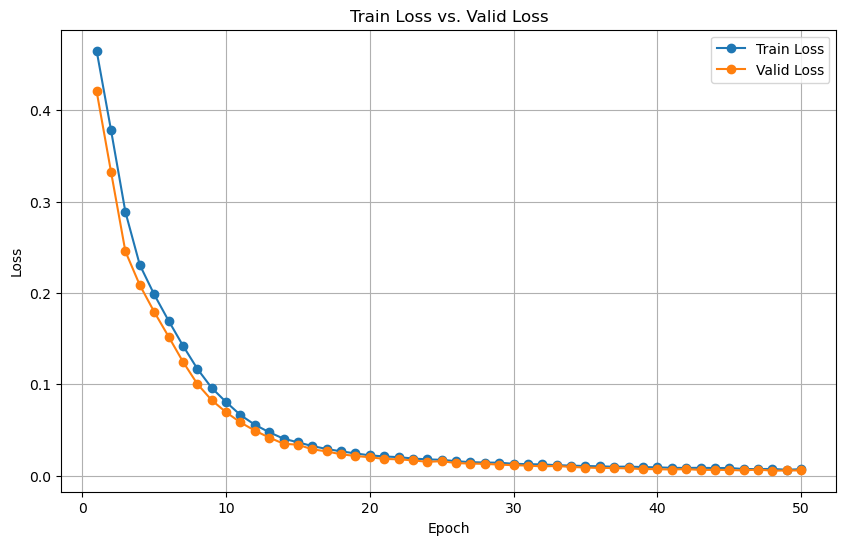

In [229]:
# Plot train loss and valid loss in one plot

# Save the figures in the "plots" folder
plots_dir = "/kaggle/working/plots"
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Save the Train Loss vs. Valid Loss plot
loss_plot_filename = os.path.join(plots_dir, "train_valid_loss_plot.png")

#Plot loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs. Valid Loss')
plt.legend()
plt.grid()
plt.savefig(loss_plot_filename)
plt.show()


# Save the Train Accuracy vs. Valid Accuracy plot
accuracy_plot_filename = os.path.join(plots_dir, "train_valid_accuracy_plot.png")
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_scores, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), valid_scores, label='Valid Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs. Valid Accuracy')
plt.legend()
plt.grid()
plt.savefig(accuracy_plot_filename)
plt.close()  # Close the figure to free up memory
plt.show()

In [230]:
#defining all the necessary functions

def track_epoch_stats(epoch_nb, lrate, train_stats, val_stats, experiment_dir):
    print("Epoch: {}".format(epoch_nb))
    print("Learning rate: {:.3g}".format(lrate))
    print("Train loss: {:.3f}".format(train_stats[0]))
    print("Train score: {:.2f}".format(train_stats[1]))
    print("Validation loss: {:.3f}".format(val_stats[0]))
    print("Validation score: {:.2f}".format(val_stats[1]))
    print()
def save_test_stats(experiment_dir, test_stats):
    stats = {'loss': test_stats[0],
             'dist_accuracy': test_stats[1]}
    stats_file = os.path.join(experiment_dir, TEST_STATS_FILE)
    with open(stats_file, 'w') as f:
        yaml.dump(stats, f, default_flow_style=False)
        
def print_header():
    '''
    Print header before train / evaluation run.
    '''
    print("         Loss  Score")

def print_eval_stats(nb_processed, loss, score):
    '''
    Log stats during train, evaluation run.
    '''
    print("  {:5d}: {:.3f}  {:2.2f}".format(nb_processed, loss, score))
    
from torch.utils.data import random_split
nb_samples = 16578

def main(args, force=False):

  experiment_dir = os.path.join(args.artifact_storage_path, 'metric_learning_emb')
  
  load_path = os.path.join(args.data_storage_path, 'metric_stage_1')
    
  # Maybe return previously trained model
  best_net_name = os.path.join(experiment_dir, 'best_model.pkl')
  if os.path.isfile(best_net_name) and (not force):
    net = load_model(best_net_name)
    if not force:
      print("Best model loaded from previous run. Not forcing training.")
      return net

  utils.initialize_experiment_if_needed(experiment_dir, evaluate_only=False)
#   utils.initialize_logger(experiment_dir)


  train_path = os.path.join(load_path, 'train.pickle')
  valid_path = os.path.join(load_path, 'valid.pickle')
  test_path  = os.path.join(load_path, 'test.pickle')
  stats_path = os.path.join(load_path, 'stats.yml')

  train_data = Hit_Pair_Dataset(train_path, 10**8)
  valid_data = Hit_Pair_Dataset(valid_path, 10**8)
  test_data  = Hit_Pair_Dataset(test_path, 10**8)


  train_dataloader = DataLoader(train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                drop_last=True,
                                pin_memory=True,
                                num_workers=8)
  valid_dataloader = DataLoader(valid_dataset,
                                batch_size=args.batch_size,
                                drop_last=True,
                                pin_memory=True,
                                num_workers=8)
  test_dataloader  = DataLoader(test_dataset,
                                batch_size=args.batch_size,
                                drop_last=True,
                                pin_memory=True,
                                num_workers=8)

  net = create_or_restore_model(
                                    experiment_dir, 
                                    train_dataset.get_dim(),
                                    args.nb_hidden, 
                                    args.nb_layer,
                                    args.emb_dim,
                                    stats_path
                                    )
  net.to(DEVICE)
  if next(net.parameters()).is_cuda:
    logging.warning("Working on GPU")
    logging.info("GPU type:\n{}".format(torch.cuda.get_device_name(0)))
  else:
    logging.warning("Working on CPU")
    

  train(net,
        args.lr_start,
        args.batch_size,
        args.max_nb_epochs,
        experiment_dir,
        train_dataloader,
        valid_dataloader)

  # Perform evaluation over test set
  try:
    net = load_best_model(experiment_dir).to(DEVICE)
    logging.warning("\nBest model loaded for evaluation on test set.")
  except:
    logging.warning("\nCould not load best model for test set. Using current.")
  test_stats = evaluate(net, experiment_dir, args.batch_size, test_dataloader, TEST_NAME)
  utils.save_test_stats(experiment_dir, test_stats)
  logging.info("Test score:  {:3.2f}".format(test_stats[1]))

  return net

In [231]:

def save_best_model(experiment_dir, net):
#     model_dir = os.path.join(experiment_dir, "model")
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    model_filename = os.path.join(experiment_dir, "trained_full_model.pt")
    torch.save(net.state_dict(), model_filename)

def save_epoch_model(experiment_dir, net):
#     model_dir = os.path.join(experiment_dir, "model")
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    model_filename = os.path.join(experiment_dir, "valid_epoch_model.pt")
    torch.save(net.state_dict(), model_filename)


def train(net, lr_start, batch_size, max_nb_epochs, experiment_dir, train_loader, valid_loader):
    optimizer = torch.optim.Adamax(net.parameters(), lr=lr_start)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    lr_end = lr_start / 10**3
    best_loss = 10**10
    # Number of epochs completed tracked in case training is interrupted
    for i in range(max_nb_epochs):
        t0 = time.time()
        logging.info("\nEpoch {}".format(i+1))
        logging.info("Learning rate: {0:.3g}".format(lr_start))

        train_stats = train_one_epoch(net, batch_size, optimizer, train_loader)
        val_stats = evaluate(net, experiment_dir, batch_size, valid_loader, 'Valid')

        logging.info("Train accuracy: {:3.2f}".format(train_stats[1]))
        logging.info("Valid accuracy: {:3.2f}".format(val_stats[1]))
        track_epoch_stats(i, lr_start, train_stats, val_stats, experiment_dir)

        scheduler.step(val_stats[0])
        lr_start = optimizer.param_groups[0]['lr']

        if val_stats[0] < best_loss:
            logging.warning("Best performance on valid set.")
            best_loss = val_stats[0]
            save_best_model(experiment_dir, net)

        save_epoch_model(experiment_dir, net)

        logging.info("Epoch took {} seconds.".format(int(time.time()-t0)))

        if lr_start < lr_end:
            break
    logging.warning("Training completed.")


def evaluate(net, experiment_dir, batch_size, eval_loader, plot_name):
    nb_batch = len(eval_loader)
    nb_eval = nb_batch * batch_size
    net.eval()

    epoch_score = 0
    epoch_loss = 0

    logging.info("\nEvaluating {} {} samples.".format(nb_eval, plot_name))
    print_header()
    with torch.no_grad():
        for i, (hits_a, hits_b, target, time1, muon1) in enumerate(eval_loader):
            hits_a = hits_a.to(DEVICE)
            hits_b = hits_b.to(DEVICE)
            target = target.to(DEVICE)
            time1 = time1.to(DEVICE)
            muon1 = muon1.to(DEVICE)

            emb_h_a = net(hits_a)
            emb_h_b = net(hits_b)

            pred = nn.functional.pairwise_distance(emb_h_a, emb_h_b)
            true_dist = target
            loss = nn.functional.hinge_embedding_loss(pred, true_dist)

            score = score_dist_accuracy(pred, target)
            epoch_score += score * 100
            epoch_loss += loss.item()

            nb_proc = (i+1) * batch_size
            if (i+1) % (nb_batch // 4) == 0:
                print_eval_stats(nb_proc, epoch_loss / (i+1), epoch_score / (i+1))

        print_eval_stats(nb_eval, epoch_loss / nb_batch, epoch_score / nb_batch)

    # Return evaluation results as a tuple
    return epoch_loss / nb_batch, epoch_score / nb_batch


# Call the train function and print the results
import os

# Check if the directory already exists.
if not os.path.exists("/kaggle/working/model"):

    # Create the directory.
    os.makedirs("/kaggle/working/model")
    
experiment_dir = "/kaggle/working/model"
lr_start = 0.001
max_nb_epochs = 10
train(net, lr_start, batch_size, max_nb_epochs, experiment_dir, train_loader, valid_loader)

         Loss  Score
    512: 0.005  99.61
   3072: 0.103  85.03
   5632: 0.083  86.01
   8192: 0.074  86.74
  10752: 0.065  88.28
  13312: 0.060  89.23
  15872: 0.054  90.31
  18432: 0.050  91.21
  20992: 0.046  92.02
  23552: 0.043  92.65
  26112: 0.041  93.25
         Loss  Score
   1536: 0.015  99.35
   3072: 0.015  99.15
   4608: 0.015  99.18
   6144: 0.014  99.19
   6656: 0.014  99.12
Epoch: 0
Learning rate: 0.001
Train loss: 0.040
Train score: 93.34
Validation loss: 0.014
Validation score: 99.12

         Loss  Score
    512: 0.011  99.61
   3072: 0.013  98.83
   5632: 0.015  98.79
   8192: 0.014  98.88
  10752: 0.014  98.88
  13312: 0.014  98.87
  15872: 0.014  98.87
  18432: 0.014  98.94
  20992: 0.013  98.96
  23552: 0.013  99.01
  26112: 0.013  99.05
         Loss  Score
   1536: 0.013  99.48
   3072: 0.009  99.48
   4608: 0.010  99.52
   6144: 0.009  99.58
   6656: 0.008  99.61
Epoch: 1
Learning rate: 0.001
Train loss: 0.013
Train score: 99.07
Validation loss: 0.008
Validat

In [232]:
def evaluate(net, experiment_dir, batch_size, eval_loader, plot_name):
    nb_batch = len(eval_loader)
    nb_eval = nb_batch * batch_size
    net.eval()

    with torch.autograd.no_grad():
        epoch_score = 0
        epoch_loss = 0
        distances = []
        embedded_points = []
        time_values = []
        muonID = []
        labels = []

        logging.info("\nEvaluating {} {} samples.".format(nb_eval, plot_name))
        print_header()
        for i, (hits_a, hits_b, target, time1, muon1) in enumerate(eval_loader):
            hits_a = hits_a.to(DEVICE)
            hits_b = hits_b.to(DEVICE)
            target = target.to(DEVICE)
            time = time1.to(DEVICE)
            muon = muon1.to(DEVICE)
#             t1 = time.time()

            emb_h_a = net(hits_a)
            emb_h_b = net(hits_b)

            pred = nn.functional.pairwise_distance(emb_h_a, emb_h_b)
            true_dist = target
            loss = nn.functional.hinge_embedding_loss(pred, true_dist)

            score = score_dist_accuracy(pred, target)
            epoch_score += score * 100
            epoch_loss += loss.item()

            nb_proc = (i+1) * batch_size
            if (i+1) % (nb_batch // 4) == 0:
                print_eval_stats(nb_proc, epoch_loss / (i+1), epoch_score / (i+1))

            # Calculate and store the pairwise distances
            distances.extend(pred.tolist())
            embedded_points.extend(emb_h_a.tolist())
            labels.extend(target.tolist())
            time_values.extend(time1.tolist())
            muonID.extend(muon1.tolist())
            
        print_eval_stats(nb_eval, epoch_loss / nb_batch, epoch_score / nb_batch)

    return epoch_loss / nb_batch, epoch_score / nb_batch, distances, embedded_points, labels, time_values, muonID

eval_loss, eval_score, distances, embedded_points, labels, time_values, muonID = evaluate(net, experiment_dir, batch_size, train_loader, 'Eval')

         Loss  Score
   6656: 0.005  99.28
  13312: 0.005  99.37
  19968: 0.005  99.39
  26624: 0.005  99.43
  26624: 0.005  99.43


In [233]:
# Convert the embedded points to a NumPy array
embedded_points_e = np.array(embedded_points)
import pandas as pd

# Create the "embed_data" folder if it doesn't exist
folder_path = '/kaggle/working/embed_data'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Convert the lists to a pandas DataFrame
data = {
    'Embedded Points': embedded_points,
    'Time': time_values,
    'muonID': muonID,
    'Target': labels
}
df = pd.DataFrame(data)

# Define the output file path inside the "embed_data" folder
output_path = os.path.join(folder_path, 'embedded_points_table.csv')

# Save the DataFrame as a CSV file
df.to_csv(output_path, index=False)

In [234]:
# Load the saved model

#from train_embed.py, load the model and Hit_Pair_Dataset
model_path = "model/trained_model.pt"
net = MLP(input_dim=3, nb_hidden=256, nb_layer=3,mean=[0,0,0], std=[1,1,1], emb_dim=3)  # Instantiate the model with the same architecture as used during training
net.to(DEVICE)
net.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
net.eval()

# Now, you can use the loaded model for inference or other tasks
# For example, to perform predictions on the test dataset:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# from hit_pair_dataset import Hit_Pair_Dataset
# # Example usage
# data_filepath = "/kaggle/input/dataset/time_dataset - time_dataset.csv (1).csv"
# nb_samples = 16218
# dataset = Hit_Pair_Dataset(data_filepath, nb_samples)

# # Access elements from the dataset
# h_a, h_b, t, ti, mi = dataset[0]

# Now all_preds contains the predictions made by the loaded model on the test dataset
# You can use these predictions for further analysis or evaluation

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1-2): 2 x Linear(in_features=256, out_features=256, bias=True)
  )
  (emb_layer): Linear(in_features=256, out_features=3, bias=True)
  (act): ReLU()
)

In [235]:
def evaluate(net, experiment_dir, batch_size, eval_loader, plot_name):
    nb_batch = len(eval_loader)
    nb_eval = nb_batch * batch_size
    net.eval()

    all_preds = []
    all_labels = []
    with torch.autograd.no_grad():
        epoch_score = 0
        epoch_loss = 0
        distances = []
        embedded_points = []
        time_values = []
        muonID = []
        labels = []

        logging.info("\nEvaluating {} {} samples.".format(nb_eval, plot_name))
        print_header()
        for i, (hits_a, hits_b, target, time1, muon1) in enumerate(eval_loader):
            hits_a = hits_a.to(DEVICE)
            hits_b = hits_b.to(DEVICE)
            target = target.to(DEVICE)
            time = time1.to(DEVICE)
            muon = muon1.to(DEVICE)
#             t1 = time.time()

            emb_h_a = net(hits_a)
            emb_h_b = net(hits_b)

            pred = nn.functional.pairwise_distance(emb_h_a, emb_h_b)
            true_dist = target
            loss = nn.functional.hinge_embedding_loss(pred, true_dist)

            score = score_dist_accuracy(pred, target)
            epoch_score += score * 100
            epoch_loss += loss.item()

            nb_proc = (i+1) * batch_size
            if (i+1) % (nb_batch // 4) == 0:
                print_eval_stats(nb_proc, epoch_loss / (i+1), epoch_score / (i+1))
                
#             pred = nn.functional.pairwise_distance(emb_h_a, emb_h_b)
            pred_labels = (pred >= 0.0).float().cpu().numpy()
            true_labels = target.cpu().numpy()

            all_preds.extend(pred_labels)
            all_labels.extend(true_labels)


            # Calculate and store the pairwise distances
            distances.extend(pred.tolist())
            embedded_points.extend(emb_h_a.tolist())
            labels.extend(target.tolist())
            time_values.extend(time1.tolist())
            muonID.extend(muon1.tolist())
            
        print_eval_stats(nb_eval, epoch_loss / nb_batch, epoch_score / nb_batch)
        

    return epoch_loss / nb_batch, epoch_score / nb_batch, distances, embedded_points, labels, time_values, muonID

eval_loss, eval_score, distances, embedded_points, labels, time_values, muonID = evaluate(net, experiment_dir, batch_size, train_loader, 'Eval')

         Loss  Score
   6656: 0.005  99.40
  13312: 0.005  99.41
  19968: 0.005  99.41
  26624: 0.005  99.43
  26624: 0.005  99.43


In [236]:
# Convert the embedded points to a NumPy array
embedded_points_e = np.array(embedded_points)
import pandas as pd

# Create the "embed_data" folder if it doesn't exist
folder_path = '/kaggle/working/embed_data'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Convert the lists to a pandas DataFrame
data = {
    'Embedded Points': embedded_points,
    'Time': time_values,
    'muonID': muonID,
    'Target': labels
}
df = pd.DataFrame(data)


# Define the output file path inside the "embed_data" folder
output_path = os.path.join(folder_path, 'embedded_points_table.csv')

# Save the DataFrame as a CSV file
df.to_csv(output_path, index=False)

In [237]:
#########################################
#  Search for the nearest neighbours in the epsilon ball #
#########################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from sklearn.neighbors import KDTree
import ast

data = pd.read_csv('/kaggle/working/embed_data/embedded_points_table.csv')

# Convert the 'Embedded Points' column from string to numerical arrays
embedded_points_e = np.array([ast.literal_eval(embedded_point) for embedded_point in data['Embedded Points']])

# Convert the 'Time', 'muonID', and 'Target' columns to numpy arrays if needed
time = data["Time"].values
muonID = data["muonID"].values
labels = data['Target'].values

optimal_radius = epsilon

# Construct the KD-Tree
kdtree = KDTree(embedded_points_e)

query_point = embedded_points_e[point_index]

# Query the KD-Tree to find the indices of points within the epsilon ball
distances, indices = kdtree.query([query_point], k=len(embedded_points_e), return_distance=True)

# Filter the indices based on the distance within the epsilon ball
epsilon_indices = indices[0][distances[0] <= epsilon]

nearest_neighbors = embedded_points_e[epsilon_indices]

len(epsilon_indices)

193

In [238]:
# Filter the time_data based on nearest neighbors
nearest_neighbor_indices = epsilon_indices  # Use the nearest neighbor indices obtained from the KDTree query
filtered_data = data.iloc[nearest_neighbor_indices]

# Access the filtered embedded points and time
filtered_embedded_points = filtered_data["Embedded Points"].values
filtered_time = filtered_data["Time"].values
filtered_muonID = filtered_data["muonID"].values

# Convert the embedded points to a NumPy array
embedded_points_np = np.array([eval(embedded_point) for embedded_point in filtered_embedded_points])

len(epsilon_indices)

193

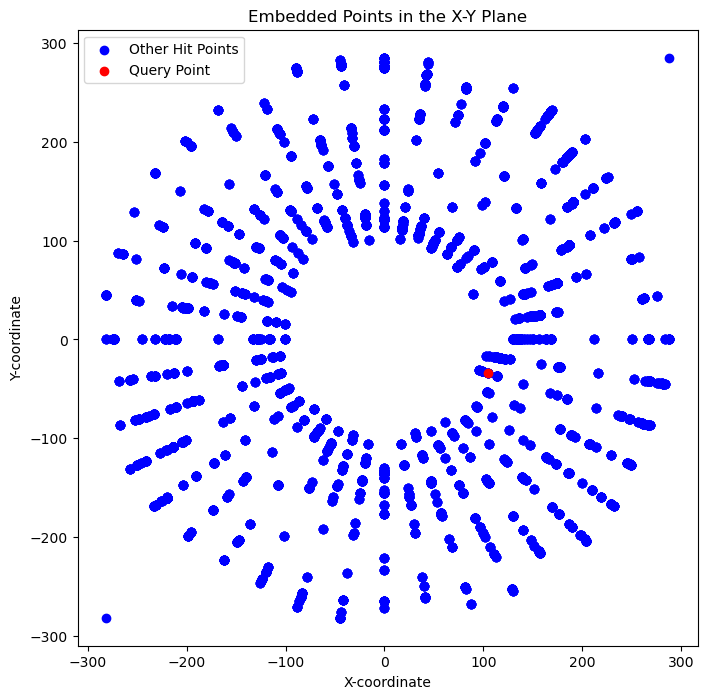

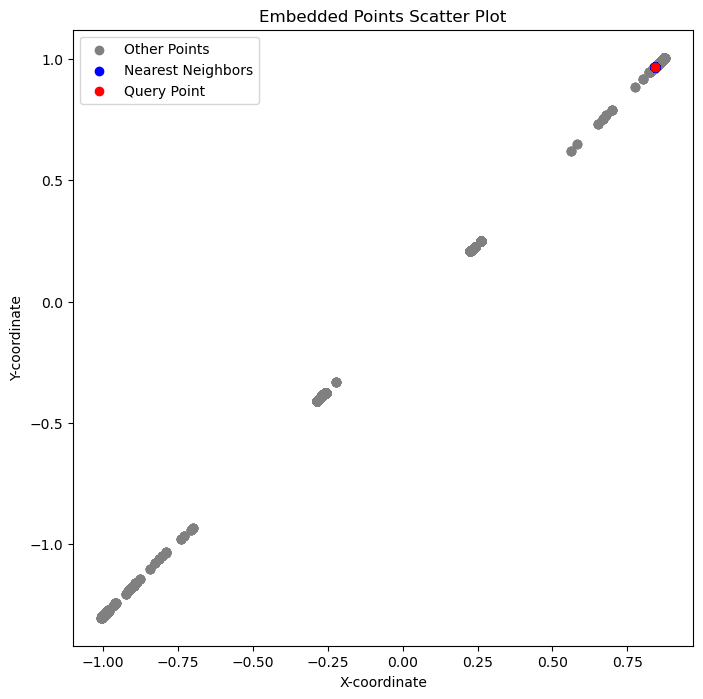

In [239]:
##############################################################
# X-Y plot with query point    #
#############################################################

df = pd.read_csv('/kaggle/input/data-sets/RecoOutPileup_TimeMod_uniform_1_recohitfile_training_data.csv')


# Extract the x and y coordinates of the embedded points
x_coords = df['x1']
y_coords = df['y1']

# Plot the x-y plane of embedded points
plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', label='Other Hit Points')
plt.scatter(x_coords[point_index], y_coords[point_index], color='red', label='Query Point')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Embedded Points in the X-Y Plane')
plt.show()

# Create the "plots" folder if it doesn't exist
output_folder = '/kaggle/working/plots'
os.makedirs(output_folder, exist_ok=True)

# Save the plot as an image in the "plots" folder
plt.savefig(os.path.join(output_folder, 'x_y_plane_plot.png'))
plt.close()

##################################
# Plot the whole embedded points #
#################################
plt.figure(figsize=(8, 8))
plt.scatter(embedded_points_e[:, 0], embedded_points_e[:, 1], color='grey', label='Other Points')
plt.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], color='blue', label='Nearest Neighbors')
plt.scatter(query_point[0], query_point[1], color='red', label='Query Point')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Embedded Points Scatter Plot')
plt.show()

# Save the plot as an image in the "plots" folder
plt.savefig(os.path.join(output_folder, 'embedded_points_scatter_plot.png'))
plt.close()

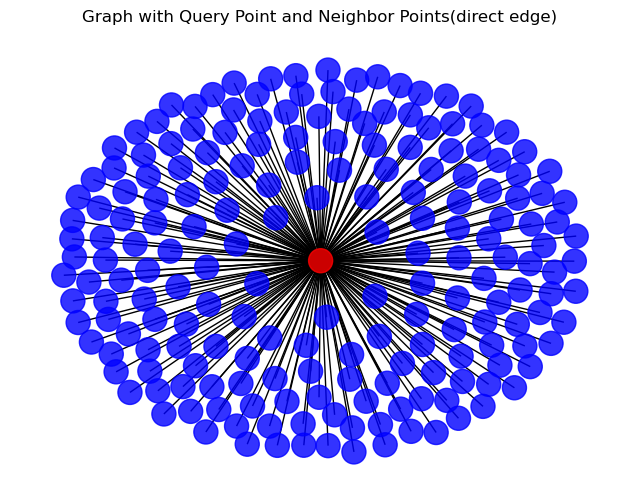

In [240]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


# Create a graph
G = nx.Graph()

# Add nodes for query point and its neighbor points
G.add_node('Query Point', color='red')
for i, neighbor_point in enumerate(nearest_neighbors):
    G.add_node(f'Neighbor {i+1}', color='blue')

# Add edges between query point and its neighbor points
for i in range(len(nearest_neighbors)):
    G.add_edge('Query Point', f'Neighbor {i+1}')

# Plot the graph
pos = nx.spring_layout(G)  # Compute node positions for visualization

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_color=[G.nodes[n]['color'] for n in G.nodes], alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='black', width=1)
# nx.draw_networkx_labels(G, pos, font_color='yellow', font_weight='bold')
plt.title('Graph with Query Point and Neighbor Points(direct edge)')
plt.axis('off')
plt.show()

In [241]:
##########################################################
# Create graph using the query point and its neighbours #
#########################################################

# Create the "plots" folder if it doesn't exist
output_folder = '/kaggle/working/plots'
os.makedirs(output_folder, exist_ok=True)

G = nx.Graph()

# Add nodes for query point and its neighbor points
G.add_node('Query Point', color='red')
for i, neighbor_point in enumerate(nearest_neighbors):
    index = indices[0][i]  # Get the corresponding index for the neighbor point
    G.add_node(f'Neighbor {index}', color='blue', index=index)

# Add edges between query point and its neighbor points
for i in range(len(nearest_neighbors)):
    index = indices[0][i]  # Get the corresponding index for the neighbor point
    G.add_edge('Query Point', f'Neighbor {index}')

# Plot the graph
pos = nx.spring_layout(G)  # Compute node positions for visualization

plt.figure(figsize=(8, 6))
node_colors = [G.nodes[n]['color'] for n in G.nodes]
node_labels = {n: G.nodes[n]['index'] if 'index' in G.nodes[n] else '' for n in G.nodes}
nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='black', width=1)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_color='black')
plt.title('Graph with Query Point {} and Neighbor Points (direct edge)'.format(point_index))
plt.axis('off')
# Save the plot as an image in the "plots" folder
plt.savefig(os.path.join(output_folder, 'graph_direct_edges.png'))
plt.close()
plt.show()



In [242]:
# Create a list to store the rows of the desired dataset
result_data = []

# Get the query point and its embedded coordinates
query_point = embedded_points_np[point_index]
z_query = query_point[2]
t_qp = time[point_index]

    # Loop through the nearest neighbors
for i in range(len(epsilon_indices)):
   # Get the neighbor point and its embedded coordinates
    neighbor_point = embedded_points_np[i]
    z_neighbor = neighbor_point[2]
    t_nn = time[i]

    # Calculate z_diff and t_diff for each neighbor
    z_diff_sqr = ((z_query*390.27-192.95) - (z_neighbor*390.27-192.95))**2
    time_diff_sqr = (t_qp - t_nn)**2

    # Append the row to the result_data list
    result_data.append([point_index, i, muonID[point_index], muonID[i], z_query, z_neighbor, t_qp, t_nn, z_diff_sqr, time_diff_sqr])

# Create a new DataFrame with the desired columns
result_df = pd.DataFrame(result_data, columns=["query_point", "nearest_neighbors", "muonID_query", "muonID_neighbor", "z_query", "z_neighbor", "t_qp", "t_nn", "z_diff_sqr", "time_diff_sqr"])


# Save the DataFrame to a new CSV file
result_df.to_csv("/kaggle/working/embed_data/refine_dataset.csv", index=False)
result_df

,query_point,nearest_neighbors,muonID_query,muonID_neighbor,z_query,z_neighbor,t_qp,t_nn,z_diff_sqr,time_diff_sqr
0,34,0,104.0,556.0,-0.801703,-0.801202,3475.0,2250.0,0.038218,1500625.0
1,34,1,104.0,972.0,-0.801703,-0.801202,3475.0,6930.0,0.038218,11937025.0
2,34,2,104.0,979.0,-0.801703,-0.801202,3475.0,11125.0,0.038218,58522500.0
3,34,3,104.0,556.0,-0.801703,-0.801202,3475.0,2250.0,0.038218,1500625.0
4,34,4,104.0,972.0,-0.801703,-0.801202,3475.0,6930.0,0.038218,11937025.0
...,...,...,...,...,...,...,...,...,...,...
188,34,188,104.0,972.0,-0.801703,-0.800324,3475.0,6930.0,0.289596,11937025.0
189,34,189,104.0,972.0,-0.801703,-0.800324,3475.0,6930.0,0.289596,11937025.0
190,34,190,104.0,104.0,-0.801703,-0.800324,3475.0,3475.0,0.289596,0.0
191,34,191,104.0,556.0,-0.801703,-0.800324,3475.0,2250.0,0.289596,1500625.0


In [243]:

df = pd.read_csv('/kaggle/working/embed_data/refine_dataset.csv')
def sigmoid(x):
 return 1/(1 + np.exp(-x))

z_diff_sqr = df['z_diff_sqr']
t_diff_sqr = df['time_diff_sqr']

def spatial_temporal_sigmoid(z_diff_sqr,time_diff_sqr,spatial_weight, temporal_weight):
  """Returns a sigmoid function value that is high if two hits are spatially and temporally close and low otherwise."""

  spatial_term = sigmoid(spatial_weight / z_diff_sqr)
  temporal_term = sigmoid(temporal_weight / (time_diff_sqr+.00001))
#   if (z_diff_sqr [0]< 0.0001):
#     return 0
  return spatial_term * temporal_term


In [244]:
df["prob"] = spatial_temporal_sigmoid(df["z_diff_sqr"],df["time_diff_sqr"],100,1)
# df['class_label'] = df.apply(class_label, axis=1)
df.to_csv("/kaggle/working/embed_data/dataset_refinement_test.csv", index=False)
df

,query_point,nearest_neighbors,muonID_query,muonID_neighbor,z_query,z_neighbor,t_qp,t_nn,z_diff_sqr,time_diff_sqr,prob
0,34,0,104.0,556.0,-0.801703,-0.801202,3475.0,2250.0,0.038218,1500625.0,0.5
1,34,1,104.0,972.0,-0.801703,-0.801202,3475.0,6930.0,0.038218,11937025.0,0.5
2,34,2,104.0,979.0,-0.801703,-0.801202,3475.0,11125.0,0.038218,58522500.0,0.5
3,34,3,104.0,556.0,-0.801703,-0.801202,3475.0,2250.0,0.038218,1500625.0,0.5
4,34,4,104.0,972.0,-0.801703,-0.801202,3475.0,6930.0,0.038218,11937025.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...
188,34,188,104.0,972.0,-0.801703,-0.800324,3475.0,6930.0,0.289596,11937025.0,0.5
189,34,189,104.0,972.0,-0.801703,-0.800324,3475.0,6930.0,0.289596,11937025.0,0.5
190,34,190,104.0,104.0,-0.801703,-0.800324,3475.0,3475.0,0.289596,0.0,1.0
191,34,191,104.0,556.0,-0.801703,-0.800324,3475.0,2250.0,0.289596,1500625.0,0.5


In [245]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Create the "plots" folder if it doesn't exist
output_folder = '/kaggle/working/plots'
os.makedirs(output_folder, exist_ok=True)

# Load the dataset
df = pd.read_csv('/kaggle/working/embed_data/dataset_refinement_test.csv')

# Create a graph with all edges between query point and nearest neighbors
graph_all_edges = nx.Graph()
for _, row in df.iterrows():
    graph_all_edges.add_edge("Query", row['nearest_neighbors'])

# Create a graph with edges only between query point and nearest neighbors with probability > 0.5
graph_filtered_edges = nx.Graph()
for _, row in df[df['prob'] > 0.51].iterrows():
    graph_filtered_edges.add_edge("Query", row['nearest_neighbors'])

# Set the positions of the nodes for visualization
pos = nx.spring_layout(graph_all_edges)

# Extract muonID_neighbor from the DataFrame
muonID_dict = dict(df[['nearest_neighbors', 'muonID_neighbor']].values)

# Create a color map for node colors based on muonID_neighbor
unique_muonID_neighbors = df['muonID_neighbor'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_muonID_neighbors)))
muonID_color_map = dict(zip(unique_muonID_neighbors, colors))

# Draw the first graph with all edges
plt.figure(figsize=(10, 8))
node_colors_all_edges = [muonID_color_map[muonID_dict[node]] if node in muonID_dict else 'red' for node in graph_all_edges.nodes]
nx.draw(graph_all_edges, pos, with_labels=True, labels=muonID_dict, node_color=node_colors_all_edges, node_size=200, font_size=10, font_weight='bold', font_color = 'white')
nx.draw_networkx_nodes(graph_all_edges, pos, nodelist=['Query'], node_color='red', node_size=2000)
nx.draw_networkx_nodes(graph_all_edges, pos, nodelist=graph_all_edges.nodes()-{'Query'}, node_color=[muonID_color_map[muonID_dict[node]] for node in graph_all_edges.nodes()-{'Query'}], node_size=800)
plt.title("Graph with All Edges")
plt.savefig(os.path.join(output_folder, 'graph_direct_edges_muon_details.png'))
plt.close()
plt.show()

# Draw the second graph with filtered edges
plt.figure(figsize=(10, 8))
node_colors_filtered_edges = [muonID_color_map[muonID_dict[node]] if node in muonID_dict else 'red' for node in graph_filtered_edges.nodes]
nx.draw(graph_filtered_edges, pos, with_labels=True, labels=muonID_dict, node_color=node_colors_filtered_edges, node_size=200, font_size=10, font_weight='bold', font_color = 'white')
nx.draw_networkx_nodes(graph_filtered_edges, pos, nodelist=['Query'], node_color='red', node_size=2000)
nx.draw_networkx_nodes(graph_filtered_edges, pos, nodelist=graph_filtered_edges.nodes()-{'Query'}, node_color=[muonID_color_map[muonID_dict[node]] for node in graph_filtered_edges.nodes()-{'Query'}], node_size=800)
plt.title("Graph with Edges (prob > 0.5)")
plt.savefig(os.path.join(output_folder, 'graph_refined.png'))
plt.close()
plt.show()


/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1067: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


In [246]:


# Load the dataset
df = pd.read_csv('/kaggle/working/embed_data/dataset_refinement_test.csv')

# Create a graph with edges only between query point and nearest neighbors with probability > 0.5
graph_filtered_edges = nx.Graph()
for _, row in df[df['prob'] > 0.51].iterrows():
    graph_filtered_edges.add_edge("Query", row['nearest_neighbors'])

# Count the number of edges in the filtered graph
num_edges_filtered = graph_filtered_edges.number_of_edges()

# Print the number of edges in the filtered graph
print("Number of edges in the filtered graph:", num_edges_filtered)

# Load the other dataset (replace 'other_dataset.csv' with the actual filename)
other_df = pd.read_csv('/kaggle/input/data-sets/RecoOutPileup_TimeMod_uniform_1_recohitfile_training_data.csv')


# Step 2: Calculate the number of rows in the refined dataset where muonID_query is equal to muonID_neighbor
num_rows_refined_dataset = df[df['muonID_query'] == df['muonID_neighbor']].shape[0]

# Step 3: Calculate the number of rows in the real dataset where muonID is equal to the muonID_neighbor in the filtered graph
num_rows_real_dataset = other_df[other_df['muonID1'].isin(df['muonID_query'])].shape[0]

# Step 4: Calculate the graph reconstruction efficiency
graph_reconstruction_efficiency = num_edges_filtered / num_rows_refined_dataset

# Step 5: Calculate the track reconstruction efficiency
track_reconstruction_efficiency = num_edges_filtered / num_rows_real_dataset

print("Graph Reconstruction Efficiency:", graph_reconstruction_efficiency)
print("Track Reconstruction Efficiency:", track_reconstruction_efficiency)

Number of edges in the filtered graph: 15
Graph Reconstruction Efficiency: 1.0
Track Reconstruction Efficiency: 0.01847290640394089


In [247]:
####################################################
#   Only for reference #
###################################################

In [248]:

# Load the saved model
model_path = "model/trained_model.pt"
net = MLP(input_dim=3, nb_hidden=256, nb_layer=3,mean=[0,0,0], std=[1,1,1], emb_dim=3)  # Instantiate the model with the same architecture as used during training
net.to(DEVICE)
net.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
net.eval()

# Now, you can use the loaded model for inference or other tasks
# For example, to perform predictions on the test dataset:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
from hit_pair_dataset import Hit_Pair_Dataset
# Example usage
data_filepath = "/kaggle/input/dataset/time_dataset - time_dataset.csv (1).csv"
nb_samples = 16218
dataset = Hit_Pair_Dataset(data_filepath, nb_samples)

# Access elements from the dataset
h_a, h_b, t, ti, mi = dataset[0]


all_preds = []
with torch.no_grad():
    for hits_a, hits_b, target, time1, muon1 in test_loader:
        hits_a = hits_a.to(DEVICE)
        hits_b = hits_b.to(DEVICE)

        # Forward pass to get predictions
        emb_h_a = net(hits_a)
        emb_h_b = net(hits_b)
        pred = nn.functional.pairwise_distance(emb_h_a, emb_h_b)

        # Convert predictions to numpy arrays if needed
        pred = pred.cpu().numpy()
        all_preds.extend(pred)

# Now all_preds contains the predictions made by the loaded model on the test dataset
# You can use these predictions for further analysis or evaluation

NameError: name 'test_dataset' is not defined

In [ ]:
############################
#   Reference training  #
###########################

#defining the model for training one epoch

import os
import time
import logging
import numpy as np
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model_dir = "/kaggle/working/model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


def train_one_epoch(net, batch_size, optimizer, train_loader):
  net.train()

  nb_batch = len(train_loader)
  nb_train = nb_batch * batch_size
  epoch_score = 0
  epoch_loss  = 0


  logging.info("Training on {} samples".format(nb_train))
  print_header()
  t0 = time.time()
  elapsed = 0
  for i, (hits_a, hits_b, target, time1, muon1) in enumerate(train_loader):
    hits_a = hits_a.to(DEVICE, non_blocking=True)
    hits_b = hits_b.to(DEVICE, non_blocking=True)
    target = target.to(DEVICE, non_blocking=True)
    time1 = time1.to(DEVICE, non_blocking=True)
    muon1 = muon1.to(DEVICE, non_blocking=True)
    '''
    hits_a = hits_a.to(DEVICE)
    hits_b = hits_b.to(DEVICE)
    target = target.to(DEVICE)
    '''
    optimizer.zero_grad()

    emb_h_a = net(hits_a)
    emb_h_b = net(hits_b)

    pred = nn.functional.pairwise_distance(emb_h_a,emb_h_b)
    true_dist = target
    loss = nn.functional.hinge_embedding_loss(pred,true_dist)
    
    torch.nn.HingeEmbeddingLoss(margin=1.0, size_average=None, reduce=None, reduction='mean')

    loss.backward()
    optimizer.step()

    score = score_dist_accuracy(pred, target)
    epoch_score += score * 100
    epoch_loss  += loss.item()

    nb_proc = (i+1) * batch_size
    if (((i+0) % (nb_batch//10)) == 0):
        print_eval_stats(nb_proc,
                               epoch_loss/(i+1),
                               epoch_score/(i+1))

  logging.info("Model elapsed:  {:.2f}".format(elapsed))

  # Save the trained model
  torch.save(net.state_dict(), os.path.join(model_dir, "ref_model.pt"))

  return epoch_loss / nb_batch, epoch_score / nb_batch



batch_size = 512

import torch.optim as optim


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net.to(DEVICE)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
# optimizer = optim.SGD(net.parameters(), lr=0.001)


# Train the model
train_losses=[]
train_scores=[]

num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss, epoch_score = train_one_epoch(net, batch_size, optimizer, train_loader)
    train_losses.append(epoch_loss)
    train_scores.append(epoch_score)
#     print(f"Epoch {epoch+1}: Loss: {epoch_loss}, Score: {epoch_score}")
    print(f"Epoch {epoch+1}: Train Loss: {epoch_loss}, Train Score: {epoch_score}")